<a href="https://colab.research.google.com/github/mkatouda/qclsample/blob/master/qiskit_qcl_regression_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Qiskitによる量子回路学習のサンプルコード: １次関数の回帰問題**
量子機械学習にパラメータ化された量子回路(PQC)を適用しNISQ量子コンピュータで実行可能としたことでブレークスルーとなった手法として，大阪大学の御手洗らにより開発された量子回路学習(Quantum Cirquit Learning: QCL)[[Phys. Rev. A. 98, 032309 (2018)]](https://doi.org/10.1103/PhysRevA.98.032309)が挙げられる．
本ノートブックでは，量子回路学習アルゴリズムをIBMの量子コンピューティングSDKである[Qiskit](https://qiskit.org/)を用いて実装した例を紹介する．

## 量子回路学習アルゴリズム
以下1-6の手順で量子・古典ハイブリッド計算が行われる．2-4のプロセスは量子コンピュータで，1,5-6のプロセスは古典コンピュータでそれぞれ計算される．  

$$
\def\bra#1{\mathinner{\left\langle{#1}\right|}}
\def\ket#1{\mathinner{\left|{#1}\right\rangle}}
\def\braket#1#2{\mathinner{\left\langle{#1}\middle|#2\right\rangle}}
$$

1.   学習データ$\{(\mathbf{x}_i, \mathbf{y}_i)\}$, $\mathbf{x}_i$は入力データのベクトル, $\mathbf{y}_i$は出力データの真の値(教師データ)}を用意する．
2.   入力$\mathbf{x}$を量子状態に埋め込む量子回路$U_\text{in}(\mathbf{x}_i)$ (特徴量マップとよぶ)を設定し，$\mathbf{x}_i$のデータを入力量子状態$\ket{\Psi_\text{in}(\mathbf{x}_i)}=U_\text{in}(\mathbf{x}_i)\ket{0}^{\otimes n}$($n$: 量子ビット数)として埋め込む．
3.   変分最適化により調整可能なパラメータを持つ量子回路U_out(θ)を設定し，入力量子状態に作用させ，出力量子状態$\ket{\Psi_\text{out}(\mathbf{x}_i,\mathbf{\theta})}= U_\text{out}(\mathbf{\theta}))\ket{\Psi_\text{in}(\mathbf{x}_i)}$を得る．
4.   出力量子状態に対し観測量の演算子を設定し，その観測量の測定値$\mathbf{y}(\mathbf{x}_i,\mathbf{\theta})$を得る．
5.   真の値$\mathbf{y}_i$と測定値$\mathbf{y}(\mathbf{x}_i,\mathbf{\theta})$間の乖離を表す損失関数$L(\mathbf{x}_i,\mathbf{\theta})$を設定し，その値を極小化する方向に向かう$\mathbf{\theta}$の候補値に更新する．
6.   3-5のプロセスを繰り返し，損失関数$L(\mathbf{x}_i,\mathbf{\theta})$を最小化するパラメータ$\mathbf{\theta}_\text{min}$を探索する．探索により得られたパラメータ$\mathbf{\theta}_\text{min}$を用いた$\mathbf{y}(\mathbf{x}_i,\mathbf{\theta}_\text{min})$を予測モデルとして採用する．

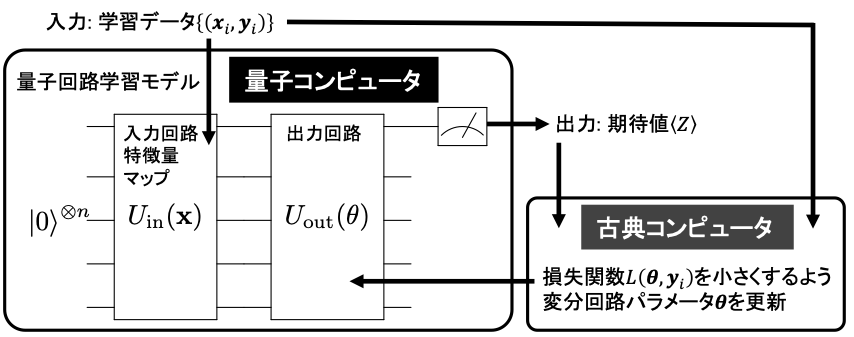


## 参考文献
1.   K. Mitarai, M. Negoro, M. Kitagawa, K. Fujii, Quantum circuit learning, Phys. Rev. A. 98, 032309 (2018). [DOI: 10.1103/PhysRevA.98.032309](https://doi.org/10.1103/PhysRevA.98.032309)
2.   T. Suzuki, M. Katouda, Predicting toxicity by quantum machine learning, J. Phys. Commun. 4, 125012 (2020). [DOI: 10.1088/2399-6528/abd3d8](https://doi.org/10.1088/2399-6528/abd3d8)
3.   御手洗 光祐, 藤井 啓祐, 量子コンピュータを用いた変分アルゴリズムと機械学習, 日本物理学会誌 74 (9), 604 (2019). [DOI: 10.11316/butsuri.74.9_604](https://www.jps.or.jp/books/gakkaishi/2019/09/74-09seriesAIphys1.pdf)
4.   河東田 道夫, ケモインフォマティクス実課題のための量子機械学習法の共同研究, RISTニュース No. 67 (2021). [記事pdf](https://www.rist.or.jp/rnews/67/67s3.pdf)

## Qiskitを用いた実装例

Qiskitのインストール

In [1]:
!pip install qiskit[visualization]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


必要なモジュールのインポート

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile
from qiskit.algorithms.optimizers import COBYLA

QCLモデルの入力パラメータの設定


In [3]:
########  パラメータ  #############
# 乱数のシード
random_seed = 0
# 乱数発生器の初期化
np.random.seed(random_seed)

# Qubit数，回路の深さ，期待値の増幅係数
nqubit = 2
c_depth = 5
Mfac = 2.0

# 量子シミュレータの設定
backendname = 'aer_simulator'
num_shots = 8192

# パラメータオプティマイザの設定
maxiter = 100
tol = 0.05

回帰する元データの設定

In [4]:
########  学習データ  #############
# 回帰する関数の定義: y=sin(x)
func_to_learn = lambda x: np.sin(x*np.pi)

# 回帰データの設定
x_min = -1.; x_max = 1.; num_x_train = 100
x_train = x_min + (x_max - x_min) * np.random.rand(num_x_train)
y_train = func_to_learn(x_train)

x_pred = np.arange(x_min, x_max, 0.02)
y_pred = func_to_learn(x_pred)

# 関数に正規分布ノイズを付加
mag_noise = 0.05
y_train += mag_noise * np.random.randn(num_x_train)

回帰する元データの可視化

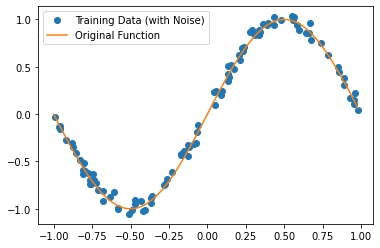

In [5]:
fig = plt.figure()
plt.plot(x_train, y_train, "o", label='Training Data (with Noise)')
plt.plot(x_pred, y_pred, label='Original Function')
plt.legend()
plt.show()
#plt.savefig('./inputdata-plot.png')

入力回路$U_\text{in}(x)$の設定: 入力回路は御手洗&藤井のQCLオリジナル論文[[Phys. Rev. A. 98, 032309 (2018)]](https://doi.org/10.1088/2399-6528/abd3d8)のものから鈴木&河東田の論文[[J. Phys. Commun. 4, 125012 (2020)]](https://doi.org/10.1088/2399-6528/abd3d8)のものへ変更

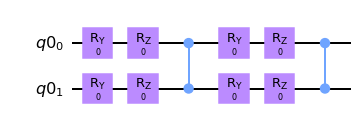

In [6]:
def U_in(x, nqubit):
    qr = QuantumRegister(nqubit)
    U = QuantumCircuit(qr)

    for j in range(2):
        for i in range(nqubit):
            U.ry(x, i)
            U.rz(x, i)
        for i in range(nqubit-1):
            U.cz(i, i+1)
        if nqubit >=3: U.cz(nqubit-1, 0)

    U.name = "U_in"
    return U

U_in(0.0, nqubit).draw('mpl')

出力回路$U_\text{out}(\mathbf{\theta})$の設定

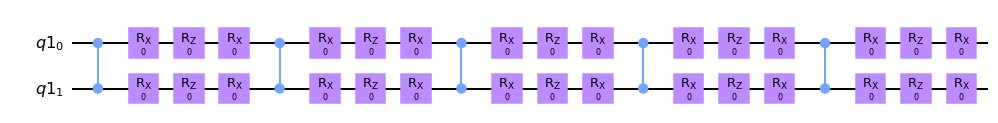

In [7]:
def U_out(nqubit, c_depth, params):
    qr = QuantumRegister(nqubit)
    U = QuantumCircuit(qr)

    for d in range(c_depth):
        for i in range(nqubit-1):
            U.cz(i, i+1)
        if nqubit >=3: U.cz(nqubit-1, 0)
        for i in range(nqubit):
            U.rx(params[nqubit*3*d+3*i], i)
            U.rz(params[nqubit*3*d+3*i+1], i)
            U.rx(params[nqubit*3*d+3*i+2], i)

    U.name = "U_out"
    return U

num_vars = 3 * nqubit * c_depth
U_out(nqubit, c_depth, np.zeros(num_vars)).draw('mpl')

量子回路学習モデルの設定

In [8]:
def pred_circ(x, nqubit, c_depth, params):
    qr = QuantumRegister(nqubit, name='q')
    cr = ClassicalRegister(1, name='c')
    qc = QuantumCircuit(qr, cr)
    u_in = U_in(x, nqubit).to_instruction()
    u_out = U_out(nqubit, c_depth, params).to_instruction()
    qc.append(u_in, qr)
    qc.append(u_out, qr)
    qc.measure(0, 0)

    return qc

def get_expval(qc, Mfac, backend, num_shots):
    qc = transpile(qc, backend=backend)
    result = backend.run(qc, shots=num_shots).result()
    counts = result.get_counts(qc)
    exp_mZ = Mfac * (counts['0'] - counts['1']) / num_shots

    return exp_mZ

def qcl_reg(x_pred, nqubit, c_depth, params, Mfac, backend, num_shots):
    y_pred = []
    for x in x_pred:
        qc = pred_circ(x, nqubit, c_depth, params)
        y_pred.append(get_expval(qc, Mfac, backend, num_shots))

    return np.array(y_pred)

出力回路$U_\text{out}(\mathbf{\theta})$の変分回路パラメータ$\mathbf{\theta}$の初期化

initial params
 [1.30357293 2.6683775  2.35097932 2.9127303  1.74439261 3.68687478
 5.42776485 0.73847443 3.2507888  0.82980839 4.50416222 2.48851651
 3.55264688 1.15158117 0.91010531 3.06654805 2.23438073 5.90890818
 4.80868039 4.70399226 5.67823859 0.52415862 3.46952761 3.67237145
 6.04402452 1.83561705 1.51317185 0.63016542 0.10323041 5.84040495]


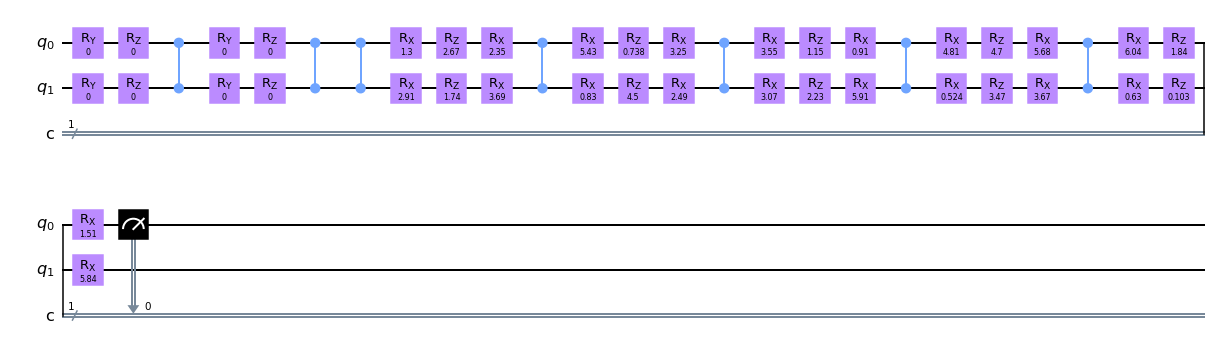

In [9]:
num_vars = 3 * nqubit * c_depth
params = np.random.rand(num_vars) * 2 * np.pi
print('initial params\n', params)
pred_circ(0.0, nqubit, c_depth, params).decompose().draw('mpl')

初期化した変分回路パラメータθを用いた回帰計算実行

In [10]:
backend = Aer.get_backend(backendname)
y_pred_reg_init = qcl_reg(x_pred, nqubit, c_depth, params, Mfac, backend, num_shots)
print('y_pred_reg_init:\n', y_pred_reg_init)

y_pred_reg_init:
 [-1.93115234 -1.89306641 -1.84130859 -1.79394531 -1.73535156 -1.66699219
 -1.60009766 -1.52783203 -1.41992188 -1.3203125  -1.24658203 -1.06884766
 -1.01318359 -0.90087891 -0.81152344 -0.66992188 -0.59423828 -0.48974609
 -0.34960938 -0.26953125 -0.14697266 -0.03222656  0.02001953  0.11962891
  0.21484375  0.28759766  0.37939453  0.46679688  0.49804688  0.60449219
  0.64355469  0.69238281  0.69042969  0.74755859  0.75        0.79492188
  0.8203125   0.82861328  0.85400391  0.84716797  0.81884766  0.79541016
  0.78466797  0.74658203  0.75732422  0.72363281  0.65966797  0.59667969
  0.56982422  0.51806641  0.46484375  0.43310547  0.38183594  0.33740234
  0.27880859  0.21191406  0.16601562  0.046875    0.01171875 -0.03857422
 -0.03662109 -0.13964844 -0.17480469 -0.17919922 -0.27783203 -0.30126953
 -0.32080078 -0.40380859 -0.41455078 -0.3984375  -0.41992188 -0.44433594
 -0.46386719 -0.46972656 -0.45410156 -0.47998047 -0.48339844 -0.4453125
 -0.45214844 -0.40869141 -0.404296

変分回路パラメータ学習用のコスト関数の設定

In [11]:
def cost_function(params):
    global iter
    cost_total = 0.0
    for i in range(len(x_train)):
        qc = pred_circ(x_train[i], nqubit, c_depth, params)
        cost = (y_train[i] - get_expval(qc, Mfac, backend, num_shots))**2
        cost_total += cost

    print('Iter: %d, Cost: %f' % (iter, cost_total))
    costs.append(cost_total)
    iter += 1

    return cost_total

変分回路パラメータ学習実行：回路パラメータの最適化アルゴリズムには[COBYLA(Constrained Optimization By Linear Approximation)法](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.COBYLA.html)を使用

In [12]:
backend = Aer.get_backend(backendname)
iter = 0; costs = []
optimizer = COBYLA(maxiter=maxiter, tol=tol)
result = optimizer.minimize(cost_function, params)

Iter: 0, Cost: 111.432301
Iter: 1, Cost: 86.462302
Iter: 2, Cost: 78.263922
Iter: 3, Cost: 79.545718
Iter: 4, Cost: 48.610459
Iter: 5, Cost: 37.567242
Iter: 6, Cost: 25.116224
Iter: 7, Cost: 103.138109
Iter: 8, Cost: 40.792729
Iter: 9, Cost: 36.630385
Iter: 10, Cost: 49.338893
Iter: 11, Cost: 49.825055
Iter: 12, Cost: 96.929586
Iter: 13, Cost: 55.980552
Iter: 14, Cost: 12.912633
Iter: 15, Cost: 121.933433
Iter: 16, Cost: 42.971507
Iter: 17, Cost: 12.417300
Iter: 18, Cost: 48.599502
Iter: 19, Cost: 114.822879
Iter: 20, Cost: 3.890473
Iter: 21, Cost: 15.504940
Iter: 22, Cost: 122.901798
Iter: 23, Cost: 26.980035
Iter: 24, Cost: 92.443578
Iter: 25, Cost: 7.210514
Iter: 26, Cost: 69.771859
Iter: 27, Cost: 52.537816
Iter: 28, Cost: 3.727239
Iter: 29, Cost: 3.917096
Iter: 30, Cost: 3.779259
Iter: 31, Cost: 63.795747
Iter: 32, Cost: 1.963697
Iter: 33, Cost: 5.659454
Iter: 34, Cost: 17.805890
Iter: 35, Cost: 61.518927
Iter: 36, Cost: 18.258911
Iter: 37, Cost: 8.726549
Iter: 38, Cost: 5.831993


学習結果の表示

In [13]:
params = result.x
y_pred_reg_final = qcl_reg(x_pred, nqubit, c_depth, params, Mfac, backend, num_shots)
print('y_pred_reg_final:\n', y_pred_reg_final)

y_pred_reg_final:
 [-0.17773438 -0.26464844 -0.31591797 -0.36083984 -0.44677734 -0.51171875
 -0.52685547 -0.60888672 -0.63867188 -0.64892578 -0.70654297 -0.73388672
 -0.76074219 -0.84619141 -0.83398438 -0.86035156 -0.87792969 -0.86669922
 -0.91894531 -0.89794922 -0.91503906 -0.93164062 -0.921875   -0.90380859
 -0.91162109 -0.92529297 -0.87158203 -0.88867188 -0.85742188 -0.85742188
 -0.81347656 -0.765625   -0.77685547 -0.72167969 -0.69775391 -0.65429688
 -0.64160156 -0.56689453 -0.56054688 -0.53125    -0.40966797 -0.43115234
 -0.34765625 -0.27392578 -0.20605469 -0.24902344 -0.16699219 -0.05664062
  0.00292969  0.00878906  0.08105469  0.13867188  0.20947266  0.26367188
  0.34570312  0.38623047  0.45410156  0.49365234  0.54736328  0.59912109
  0.66699219  0.68310547  0.79101562  0.80175781  0.85791016  0.90917969
  0.94433594  0.96386719  1.00048828  1.03466797  1.07324219  1.10986328
  1.12988281  1.14599609  1.13818359  1.15039062  1.12890625  1.14355469
  1.11572266  1.13330078  1.1157

損失関数の最適化結果の可視化

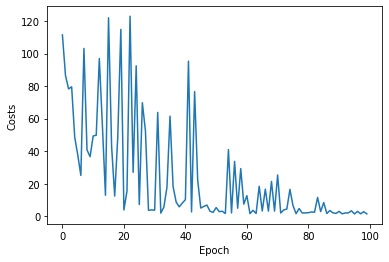

In [14]:
fig = plt.figure()
plt.plot([i for i in range(len(costs))], costs)
plt.xlabel('Epoch')
plt.ylabel('Costs')
plt.show()
#plt.savefig('./qcl-epoch.png')

量子回路学習で決定した回帰モデルの可視化

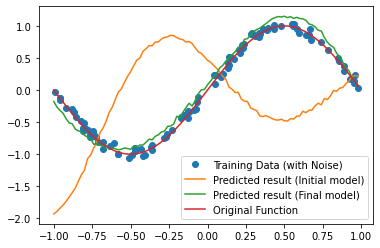

In [15]:
fig = plt.figure()
plt.plot(x_train, y_train, "o", label='Training Data (with Noise)')
plt.plot(x_pred, y_pred_reg_init, label='Predicted result (Initial model)')
plt.plot(x_pred, y_pred_reg_final, label='Predicted result (Final model)')
plt.plot(x_pred, y_pred, label='Original Function')
plt.legend()
plt.show()
#plt.savefig('./qcl-regplot.png')